# Visualization_v3

In [1]:
import importlib
import confocal
importlib.reload(confocal)

import glob, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio
import re
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.measurements import center_of_mass
from scipy.interpolate import interp2d,RegularGridInterpolator
from random import random
from tqdm import tqdm
from scipy.interpolate import interp1d

from itertools import accumulate
from skimage.measure import find_contours
from scipy.spatial import ConvexHull
import cv2

## Max Projection of benchmark HUVEC files

In [2]:
if False:
    maxproj_do_plot = False
    globstrings = [
        'datasets/AFM-C HUVEC 20200626/Group 1.export/Intensity.png.export/Intensity_*_CH.png',
        'datasets/AFM-C HUVEC 20200626/Group 2.export/Intensity.png.export/Intensity_*_CH.png',
        'datasets/AFM-C HUVEC 20200626/Group 3.export/Intensity.png.export/Intensity_*_CH.png',
        'datasets/AFM-C HUVEC 20200626/Group 4.export/Intensity.png.export/Intensity_*_CH.png',
        'datasets/AFM-C HUVEC 20200626/Group 5.export/Intensity.png.export/Intensity_*_CH.png'
    ]
    descs = ['group_1','group_2','group_3','group_4','group_5',]

    destdir = 'AFM-C HUVEC 20200626/Processing/maxproj/'
    # fnames = glob.glob(globstring)
    # print(len(fnames))
    for globstring, desc in zip(globstrings, descs):
        confocal.max_projection(globstring, do_plot=maxproj_do_plot, do_save=True, destdir=destdir, 
                filedesc=desc)
        plt.show()

## Analyze Group 1 (Dev)

In [3]:
cs1 = confocal.make_huvec26_obj(1)
print(cs1.data.keys())

dict_keys(['full_image', 'nucleus_mask', 'cyto_mask', 'source_folder', 'blue_linear2D', 'green_linear2D', 'red_linear2D', 'nucleus_linear_mask2D', 'cyto_linear_mask2D', 'cyto_linear3D', 'nucleus_linear3D', 'other_linear3D'])


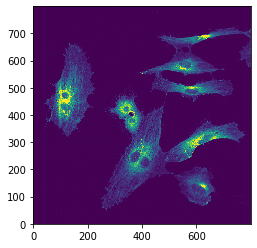

In [4]:
res = cs1.render_image('cyto_linear3D',sliced=40, series=False, do_plot=True)

slices is None


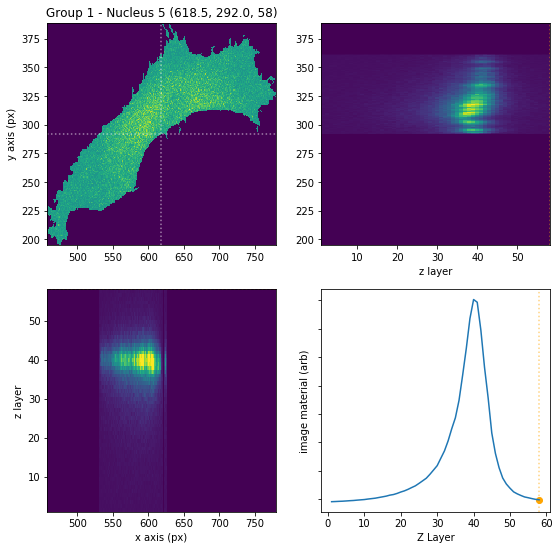

slices is None


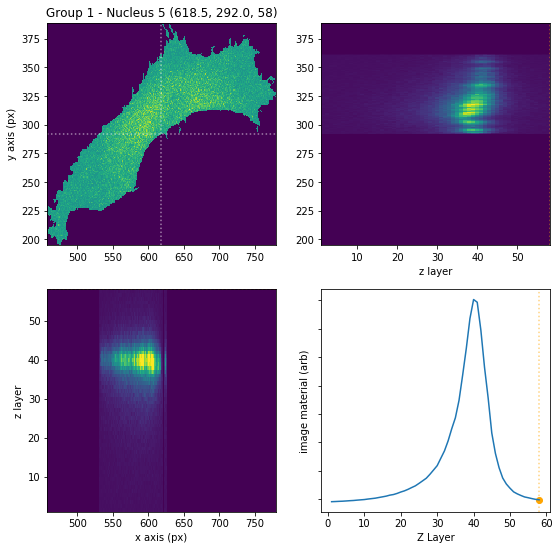

In [5]:
cyto_id = 11

cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test', debug=False, series=False,
                   mask=cs1.data['cyto_linear_mask2D'][cyto_id])
cs1.four_panel('cyto_test',desc='Group 1 - Nucleus 5', z=58)

plt.show()

cs1.create_cropped('cyto_linear3D', cropped_name='green_test', debug=False, series=False, window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent'])
cs1.four_panel('cyto_test',desc='Group 1 - Nucleus 5', z=58)

plt.show()


layer 1
slices is None


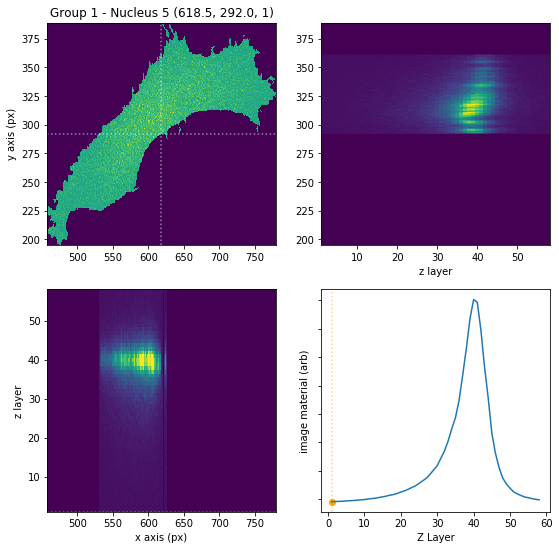

In [6]:
for f in cs1.data['full_image']:
    print('layer', f)
    cs1.create_cropped('cyto_linear3D', cropped_name='Cyto_test', debug=False, series=False, window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent'])
    cs1.four_panel('cyto_test',desc='Group 1 - Nucleus 5', z=f)

    plt.show()
    break

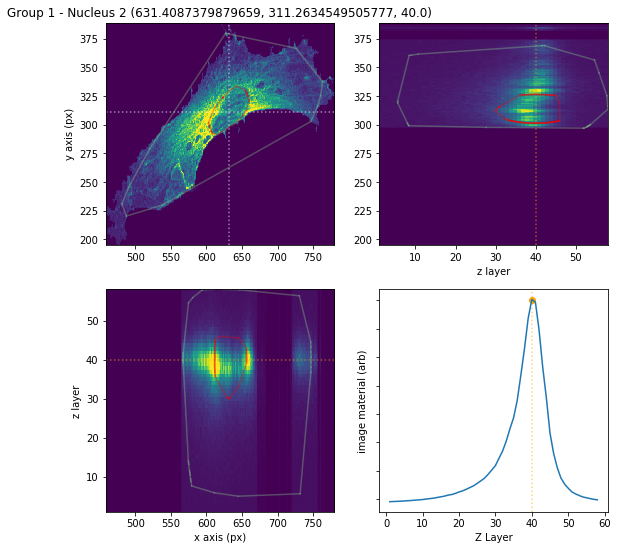

In [7]:
cyto_id=11
cs1.create_cropped('cyto_linear3D', cropped_name='green_test', debug=False, series=False,
                   mask=cs1.data['cyto_linear_mask2D'][cyto_id])
cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test', debug=False, series=False,
                   mask=cs1.data['nucleus_linear_mask2D'][cyto_id])
cs1.find_envelope3D('cyto_test', 'cyto_cropped_env', n_angle=320, max_r=200, pct=0.95)
cs1.find_envelope3D('nucleus_test', 'nucleus_cropped_env', n_angle=320, max_r=200, pct=0.95)

cs1.four_panel('cyto_test', center_on='nucleus_test',
               envelopes=[{'target': 'cyto_cropped_env', 'color': 'lightgreen'}, 'nucleus_cropped_env'], desc='Group 1 - Nucleus 2', do_save='images/first_fitting.png' )
# plt.show()


slices is None
Cannot do XY contour for env 0
Cannot do XY contour for env 1


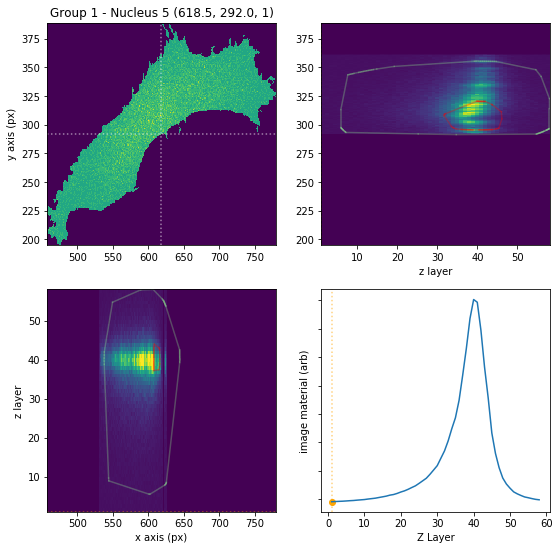

In [8]:
for f in cs1.data['full_image']:
#     cs1.render_image('green_test', sliced=f, do_plot=True)
#     plt.title(f)

    cs1.four_panel('cyto_test', z=f,
               envelopes=[{'target': 'cyto_cropped_env', 'color': 'lightgreen'}, 'nucleus_cropped_env'], desc='Group 1 - Nucleus 5' )

    plt.show()
    break

### Generate contours from envelopes

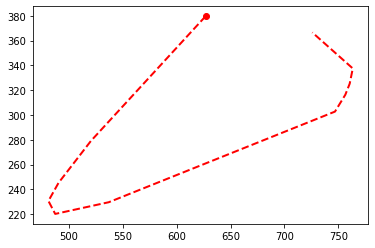

In [9]:
envelope_target = 'cyto_cropped_env'
env = cs1.data[envelope_target]
slice_xy = 40
thickness = 1
scatter_too = False

applies = abs(env[:, :, 2] - slice_xy) < thickness

res = env[applies]
if scatter_too:
    plt.scatter(res.T[0], res.T[1], color='red', alpha=0.5)
# print('res:', res)

if not len(res):
    print('Cannot do XY contour for env %d' % nenv)
hull = ConvexHull(res[:, [0,1]])
# for simplex in hull.simplices:
#     print(res[simplex,0], res[simplex,1])
#     plt.plot(res[simplex, 0], res[simplex, 1], alpha=0.75)
    
    
plt.plot(res[hull.vertices,0], res[hull.vertices,1], 'r--', lw=2)
plt.plot(res[hull.vertices[0],0], res[hull.vertices[0],1], 'ro')
plt.show()



In [47]:
res[hull.vertices,0]

array([626.85454842, 520.4282676 , 490.43871396, 481.05736947,
       487.35152283, 537.05412682, 746.88587092, 756.47668883,
       760.53490274, 763.40397011, 725.87545792])

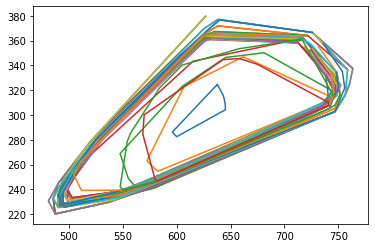

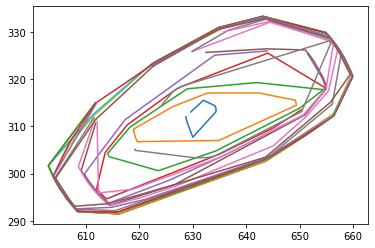

In [48]:
def produce_envelope_contour(self, target, thickness=1, debug=False):
    
    env = cs1.data[target]
    
    contours = {}
    if debug: print('range:', int(np.min(env[:,:,2])), int(np.max(env[:,:,2])+1))
    for slice_xy in np.arange(int(np.min(env[:,:,2])), int(np.max(env[:,:,2])+1)):
        applies = abs(env[:, :, 2] - slice_xy) < thickness

        res = env[applies]
#         if scatter_too:
#             plt.scatter(res.T[0], res.T[1], color='red', alpha=0.5)
        # print('res:', res)

        if not len(res):
            print('Cannot do XY contour for level', slice_xy)

        hull = ConvexHull(res[:, [0,1]])

        vertices = np.array([res[hull.vertices,0], res[hull.vertices,1]])
        if debug: print(slice_xy,np.shape(res[hull.vertices,0]))
        contours[slice_xy] = vertices
        plt.plot(vertices[0], vertices[1])
#         break

    return contours


cyto_contour = produce_envelope_contour(cs1, 'cyto_cropped_env')
plt.show()
nucleus_contour = produce_envelope_contour(cs1, 'nucleus_cropped_env')
plt.show()

In [49]:
importlib.reload(confocal)

<module 'confocal' from '/Users/asears/work/confocal/confocal.py'>

Moving to mean


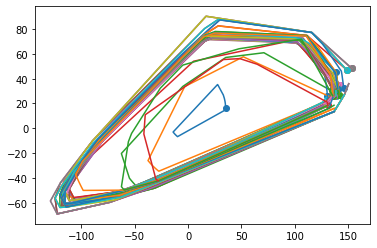

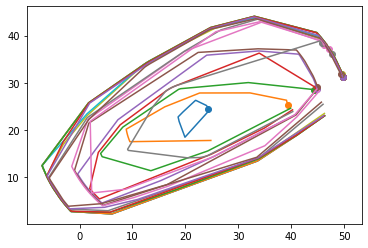

In [52]:
cyto_contour,moved = confocal.heal_contour(cyto_contour)
# print(res.keys())
nucleus_contour, moved = confocal.heal_contour(nucleus_contour, move_to_mean=moved)


In [53]:
nucleus_contour.keys(),cyto_contour.keys()
nucleus_contour = {n: nucleus_contour[n] for n in nucleus_contour if n%2==0}
cyto_contour = {n: cyto_contour[n] for n in cyto_contour if n%4==0}

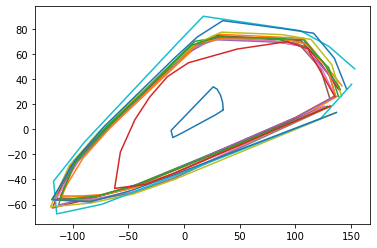

In [54]:
import itertools
def reparam_contour(c,npts=21):
#     print(c.keys())
    for level in c:
#         print(c[level].shape)
        lx = c[level][0]
        ly = c[level][1]
        
        M = cv2.moments(c[level].T.astype(np.int32))
        cX, cY = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
        
        dist = np.array([0,]+[np.sqrt((i1-i0)**2+(j1-j0)**2) for i0,i1,j0,j1 in zip(lx[1:],lx,ly[1:],ly)])
        sumdist = np.array(list(itertools.accumulate(dist)))
#         print('dist shape:', dist.shape, sumdist.shape, sumdist)
        
        fx = interp1d(sumdist,lx)
        fy = interp1d(sumdist,ly)
        
        
        
        gd = np.linspace(0,sumdist[-1],101)
        gx,gy = fx(gd), fy(gd)
        gtheta =np.unwrap(np.arctan2((gy-cY),(gx-cX)))
        afterpt = np.argmax(gtheta>gtheta[0]+np.pi)

        #         print(gtheta)
#         print('targets:')
        if False:
            plt.plot(gd,gtheta)
    #         plt.axhline(0)
            plt.show()

        if False:
            plt.scatter(gx,gy)

    #         plt.show()

            plt.plot(lx, ly)
            plt.scatter(cX,cY)

            print('Afterpt:', 0,afterpt, gtheta[0], gtheta[afterpt])
            plt.scatter(fx(gd[afterpt]),fy(gd[afterpt]))
            plt.scatter(lx[0],ly[0])

            plt.show()
        
        hd = gd[afterpt] # halfway distance
        
        gd1 = np.linspace(0,hd,npts//2+1)
        gd2 = np.linspace(hd,sumdist[-1],npts//2)[1:]

        newx = np.hstack([fx(gd1), fx(gd2)])
        newy = np.hstack([fy(gd1), fy(gd2)])
        
        if False:
            plt.scatter(newx,newy)
            plt.title('broken up')
            plt.scatter(fx(gd[afterpt]),fy(gd[afterpt]))
            plt.scatter(cX,cY, marker='s')

            plt.scatter(lx[0],ly[0])
            plt.show()
#         break
#         print(np.shape(c[level]),np.shape(np.array([newx,newy])))
        c[level] = np.array([newx,newy])
    
    return c
        

        
#         plt.scatter(np.mean(c[level][0]),np.mean(c[level][1]))
#         plt.scatter(center_of_mass(c[level])[0],center_of_mass(c[level])[1])
#         ltheta = 
#         fx = interp1d()
#         break
    
edited_c = reparam_contour(cyto_contour)
for l in edited_c:
#     print(edited_c[l])
    plt.plot(edited_c[l][0],edited_c[l][1])
# plt.scatter(cX,cY)

Moving to mean
max level: 4 56
max level: 30 46
Wrote meta (for AFM-C HUVEC 20200626 Group #1, Cell #2) to export_contours/test_reply4/file.txt


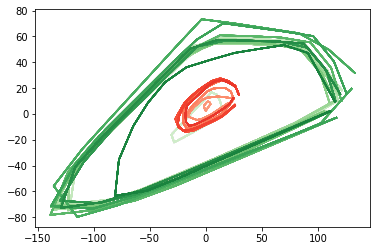

In [57]:
# X/Y Pixel scale
#     0.397 um/pixel

# Z-slice distance:
#     Group 1 - 0.35 um
#     Group 2 - 0.3 um
#     Group 3 - 0.35 um
#     Group 4 - 0.3 um
#     Group 5 - 0.3 um

# nuc_mean = [np.mean()]

cyto_contour_reparam = reparam_contour(cyto_contour)
nucleus_contour_reparam = reparam_contour(nucleus_contour)


export_dir = 'export_contours/test_reply4/'
cyto_meta = confocal.export_contours(cyto_contour_reparam, ncvar='NCY', filen='C_Cyto_Z', scaling=(0.397, 0.397, 0.35),
            export_dir=export_dir, color_range='green', move_to_mean=None, half_idx=10)
nuc_meta = confocal.export_contours(nucleus_contour_reparam, ncvar='NC', filen='C_Nuc_Z', scaling=(0.397, 0.397, 0.35),
            export_dir=export_dir, color_range='red', move_to_mean=cyto_meta['move_to_mean'], half_idx=10)


os.makedirs(export_dir, exist_ok=True)
meta_fname = os.path.join(export_dir,'file.txt')
confocal.export_contours_meta('AFM-C HUVEC 20200626 Group #1, Cell #2', meta_fname, cyto_meta, nuc_meta)

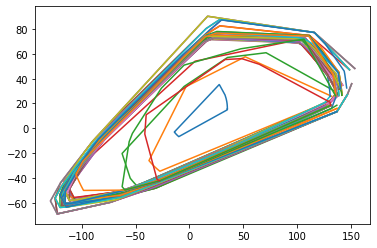

In [25]:
for _ in cyto_contour:
    plt.plot(cyto_contour[_][0],cyto_contour[_][1])

Moving to mean


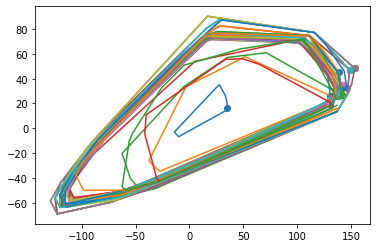

{4: array([[ 35.12356242,  35.1180771 ,  35.10162328,  35.07420733,
          35.0358399 ,  34.98653586,  34.92631435,  34.85519872,
          34.77321657,  34.6803997 ,  34.57678412,  34.46241002,
          34.05520108,  33.89827808,  32.95759313,  27.94046053,
          27.56545544,  27.56545544, -14.0652829 , -13.68624016,
         -13.29923279, -12.90441093, -12.50192774, -12.09193936,
         -11.67460484, -11.25008609,  -9.93508482,  35.10162328,
          35.1180771 ],
        [ 16.01290468,  16.56987044,  17.12662013,  17.68293777,
          18.23860753,  18.79341386,  19.34714151,  19.89957569,
          20.45050206,  20.99970692,  21.5469772 ,  22.09210059,
          23.71247935,  24.24691   ,  26.86704729,  34.84553737,
          35.2573773 ,  35.2573773 ,  -3.02657128,  -3.43469816,
          -3.83528054,  -4.22816302,  -4.61319319,  -4.99022167,
          -5.3591022 ,  -5.71969168,  -6.75033135,  14.89918922,
          15.45593892]]),
 5: array([[131.71728069,  51.6788497

In [23]:
def heal_contour(contours, move_to_mean=None):

    if move_to_mean is None:
        print('Moving to mean')
        xm = np.mean(np.hstack([contours[_][0] for _ in contours]))
        ym = np.mean(np.hstack([contours[_][1] for _ in contours]))
    else:
        xm, ym = move_to_mean
    
    new_contours = {}
    for level,c in contours.items():

        # re-center contour
        
        c = np.array([[_-xm for _ in c[0]], [_-ym for _ in c[1]]])

        # Connect beginning to end
        
        c = np.hstack([c, [[c[0][0]],[c[1][0]]]])        

        # Verify direction of rotation; reverse if necessary

        dx = c[0][1:]-c[0][:-1]
        dy = c[1][1:]+c[1][:-1]
        area = np.dot(dx, dy)/2.0 # for all points, the sum of: (x2 − x1)(y2 + y1)
#         print('area:',area)
        if area > 0: c = np.array([c[0][::-1], c[1][::-1]]) # reverse
            
        # Identify farthest point in x, and rotate contour indices
        
        idx = np.argmax(c[0])
        c = np.roll(c,-idx,axis=1)
        idx = np.argmax(c[0])
        
        plt.plot(c[0],c[1])
        plt.scatter(c[0][idx], c[1][idx])        
        
        new_contours[level] = c
    
    plt.show()
    
    return new_contours
        
heal_contour(cyto_contour)
        

In [97]:
foo = list(range(10))
len(foo), len([foo[0],]+foo[:-1])

(10, 10)

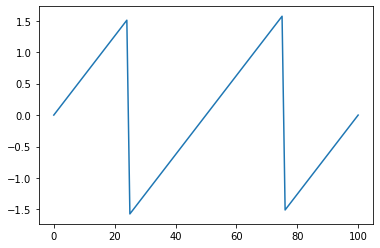

In [107]:
foo0 = np.cos(np.linspace(0,2*np.pi,101))
foo1 = np.sin(np.linspace(0,2*np.pi,101))
plt.plot(np.arctan(foo1/foo0))

## Quantifying uncertainty in the volumetric envelope

In [55]:
import confocal
importlib.reload(confocal)

<module 'confocal' from '/Users/asears/work/confocal/confocal.py'>

cwd: /Users/asears/work/confocal
Found 26 files, ie: HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/Intensity.png.export/Intensity_Z23_CH.png
Results: 26 files w/ indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
cwd: /Users/asears/work/confocal
Found 41 files, ie: HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/objects/Nucleus_9.png
Results: 41 files w/ indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
cwd: /Users/asears/work/confocal
Found 41 files, ie: HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/objects/Cytoplasm_8.png
Results: 41 files w/ indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
non-series
item

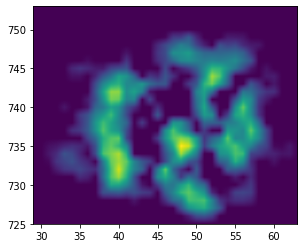

In [17]:
cs1 = confocal.make_default_obj(1, quiet=False)

Cell: 20


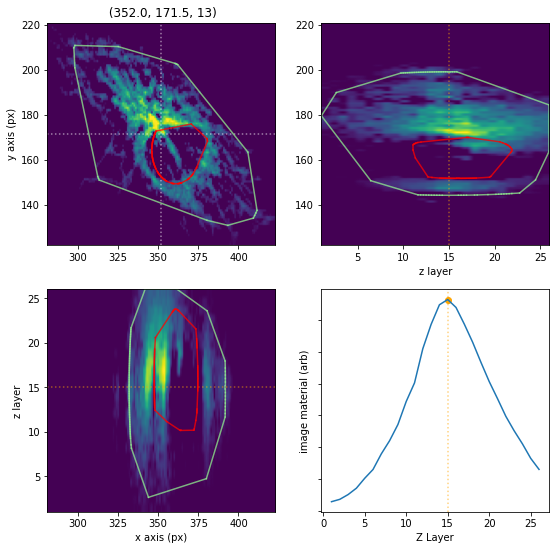

In [18]:
for cyto_id in sorted(cs1.data['cyto_linear_mask2D'].keys()):
    cyto_id=20
    print('Cell:', cyto_id)
    
    if False: # windowed
        cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test_%02d' % cyto_id, debug=False, series=False,
                           mask=None,window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent']) # 
        cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test_%02d' % cyto_id, debug=False, series=False,
                           mask=None,window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent']) # cs1.data['nucleus_linear_mask2D'][cyto_id]
    else: # masked
        cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test_%02d' % cyto_id, debug=False, series=False,
                           mask=cs1.data['cyto_linear_mask2D'][cyto_id]) # 
        cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test_%02d' % cyto_id, debug=False, series=False,
                           mask=cs1.data['cyto_linear_mask2D'][cyto_id]) # cs1.data['nucleus_linear_mask2D'][cyto_id]

    
    cs1.find_envelope3D('cyto_test_%02d' % cyto_id, 'cyto_cropped_env_%02d' % cyto_id, n_angle=320, max_r=200,
                        pct=0.95)
    cs1.find_envelope3D('nucleus_test_%02d' % cyto_id, 'nucleus_cropped_env_%02d' % cyto_id, n_angle=320, max_r=200,
                        pct=0.95)

    cs1.four_panel('cyto_test_%02d' % cyto_id,
                   envelopes=[{'target': 'cyto_cropped_env_%02d' % cyto_id, 'color': 'lightgreen'},
                              'nucleus_cropped_env_%02d' % cyto_id])
    plt.show()
    break


In [74]:
def custom_find_envelope3D(self, target, result, n_angle=40, n_r=41, max_r=30, pct=0.95, force_int_z=True, 
                compute_uncertainty=False, r_scaling=(1.0,1.0,1.0)):

    x0 = self.getCoM(target)
    if force_int_z: x0 = [x0[0], x0[1], int(x0[2])]

    envelope = np.zeros((n_angle, n_angle, 3))
    full_record = np.zeros((n_angle, n_angle, n_r))
    full_record_r = np.zeros((n_angle, n_angle, 3))
    
    rspace = np.linspace(0, max_r, n_r)
    phi_space = np.linspace(-np.pi / 2, np.pi / 2, envelope.shape[0])
    theta_space = np.linspace(0, 2 * np.pi, envelope.shape[1])

    def get_pct(x, pct=0.95):
        x_min = np.repeat(np.expand_dims(np.min(x, 0) * pct, 0), np.shape(x)[0], 0)
        return np.argmin(x_min - x < 0, 0)

    for i, phi in enumerate(phi_space):
        x0_repeats = np.array([[x0]]).repeat(len(theta_space), 1)
        x_nor = np.array([[[np.cos(th0) * np.cos(phi),
                            np.sin(th0) * np.cos(phi),
                            np.sin(phi)] for th0 in theta_space]])

        r_repeats = np.expand_dims(np.expand_dims(rspace, 1), 1)
        radial_xy = x0_repeats + x_nor * r_repeats

        indata = self.data[target]['fxn'](radial_xy)
#         print(indata.shape)
#         print(x_nor.shape)
        full_record[i] = indata.T
        full_record_r[i] = np.squeeze(x_nor)

        envelope[i] = np.array([radial_xy[arg, i, :]
                                for arg, i in zip(get_pct(list(accumulate(-indata)), pct=pct),
                                                  range(len(np.argmin(list(accumulate(-indata)), 0))))])

    self.data[result] = envelope
    
    res = {
        'full_record':full_record, # the [angle x angle x interpolated-data] (no accumulation)
        'full_record_r':'full_record_r', # the unit norm vector direction used
    }
    
    if compute_uncertainty:
        for phin in range(np.shape(res)[0]):
        for thetan in range(np.shape(res)[1]):
            accumulated = np.array(list(accumulate(-res[phin][thetan])))
            accumulated /= np.min(accumulated)
    #         plt.plot(accumulated)
    #         plt.axhline(0.95, linestyle=':')
            u1 = np.argmax(accumulated>0.95)-np.argmax(accumulated>0.9)
            u2 = np.argmax(accumulated>0.99)-np.argmax(accumulated>0.95)
            if u1>0: ac.update([u1])
            if u2>0: bc.update([u2])
            # Not clear what's happening with u1==u2==0, but the accumulation line is constant. Ok to skip.
#             if u1==0:
#                 plt.plot(accumulated)
#                 plt.axhline(0.95, linestyle=':')
#                 plt.show()
    #         print(np.argmax(accumulated>0.9), np.argmax(accumulated>0.95), np.argmax(accumulated>0.99))

        idx1 = np.argmax(np.array(list(ac.items())).T[1])
        idx2 = np.argmax(np.array(list(bc.items())).T[1])
        
        uncertainty1_mode_px = np.array(list(ac.items())).T[0][idx1]
        uncertainty2_mode_px = np.array(list(bc.items())).T[0][idx2]
        
        res.update({
            'uncertainty1_px':None,
            'uncertainty1_r':None,
            'uncertainty1_histogram_px':None,
            'uncertainty2_px':None,
            'uncertainty2_r':None,
            'uncertainty2_histogram_px':None,
        })
        
        print('Uncertainty:',,)
    #     break

    
    return full_record, full_record_r
    



In [76]:
#     cs1.find_envelope3D('nucleus_test_%02d' % cyto_id, 'nucleus_cropped_env_%02d' % cyto_id, n_angle=320, max_r=200,
#                         pct=0.95)


# res = custom_find_envelope3D(cs1,'cyto_test_%02d' % cyto_id, 'cyto_exp_env_%02d', n_r=101,max_r=200)
res, res_r = custom_find_envelope3D(cs1,'nucleus_test_%02d' % cyto_id, 'nucleus_exp_env_%02d', n_r=101,max_r=30)

In [77]:
from collections import Counter

for cyto_id in sorted(cs1.data['cyto_linear_mask2D'].keys()):
#     cyto_id=39
    ac = Counter()
    bc = Counter()
    
    if True: # windowed
        cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test_%02d' % cyto_id, debug=False, series=False,
                           mask=None,window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent']) # 
        cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test_%02d' % cyto_id, debug=False, series=False,
                           mask=None,window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent']) # cs1.data['nucleus_linear_mask2D'][cyto_id]
    else: # masked
        cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test_%02d' % cyto_id, debug=False, series=False,
                           mask=cs1.data['cyto_linear_mask2D'][cyto_id]) # 
        cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test_%02d' % cyto_id, debug=False, series=False,
                           mask=cs1.data['cyto_linear_mask2D'][cyto_id]) # cs1.data['nucleus_linear_mask2D'][cyto_id]


    
    res, res_r = custom_find_envelope3D(cs1,'cyto_test_%02d' % cyto_id, 'cyto_exp_env_%02d', n_r=201,max_r=200)
#     res = custom_find_envelope3D(cs1,'nucleus_test_%02d' % cyto_id, 'nucleus_exp_env_%02d', n_r=101,max_r=30)
    print(res.shape)
    for phin in range(np.shape(res)[0]):
        for thetan in range(np.shape(res)[1]):
            accumulated = np.array(list(accumulate(-res[phin][thetan])))
            accumulated /= np.min(accumulated)
    #         plt.plot(accumulated)
    #         plt.axhline(0.95, linestyle=':')
            u1 = np.argmax(accumulated>0.95)-np.argmax(accumulated>0.9)
            u2 = np.argmax(accumulated>0.99)-np.argmax(accumulated>0.95)
            if u1>0: ac.update([u1])
            if u2>0: bc.update([u2])
            # Not clear what's happening with u1==u2==0, but the accumulation line is constant. Ok to skip.
#             if u1==0:
#                 plt.plot(accumulated)
#                 plt.axhline(0.95, linestyle=':')
#                 plt.show()
    #         print(np.argmax(accumulated>0.9), np.argmax(accumulated>0.95), np.argmax(accumulated>0.99))

    idx1 = np.argmax(np.array(list(ac.items())).T[1])
    idx2 = np.argmax(np.array(list(bc.items())).T[1])
    print('Cell:', cyto_id,'-',np.array(list(ac.items())).T[0][idx1],np.array(list(bc.items())).T[0][idx2])
#     break

(40, 40, 201)
Cell: 1 - 2 2
(40, 40, 201)
Cell: 2 - 1 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


(40, 40, 201)
Cell: 3 - 1 1
(40, 40, 201)
Cell: 4 - 2 2
(40, 40, 201)
Cell: 5 - 1 2
(40, 40, 201)
Cell: 6 - 1 1
(40, 40, 201)
Cell: 7 - 1 2
(40, 40, 201)
Cell: 8 - 1 3
(40, 40, 201)
Cell: 9 - 1 1
(40, 40, 201)
Cell: 10 - 1 1
(40, 40, 201)
Cell: 11 - 1 1
(40, 40, 201)
Cell: 12 - 1 1
(40, 40, 201)
Cell: 13 - 1 2
(40, 40, 201)
Cell: 14 - 1 2
(40, 40, 201)
Cell: 15 - 2 2
(40, 40, 201)
Cell: 16 - 2 2
(40, 40, 201)
Cell: 17 - 1 1
(40, 40, 201)
Cell: 18 - 1 1
(40, 40, 201)
Cell: 19 - 2 2
(40, 40, 201)
Cell: 20 - 1 1
(40, 40, 201)
Cell: 21 - 1 2
(40, 40, 201)
Cell: 22 - 1 1
(40, 40, 201)
Cell: 23 - 1 2
(40, 40, 201)
Cell: 24 - 1 2
(40, 40, 201)
Cell: 25 - 1 2
(40, 40, 201)
Cell: 26 - 1 1
(40, 40, 201)
Cell: 27 - 1 2
(40, 40, 201)
Cell: 28 - 1 2
(40, 40, 201)
Cell: 29 - 1 2
(40, 40, 201)
Cell: 30 - 1 1
(40, 40, 201)
Cell: 31 - 2 1
(40, 40, 201)
Cell: 32 - 1 1
(40, 40, 201)
Cell: 33 - 1 1
(40, 40, 201)
Cell: 34 - 1 1
(40, 40, 201)
Cell: 35 - 1 3
(40, 40, 201)
Cell: 36 - 1 1
(40, 40, 201)
Cell: 3

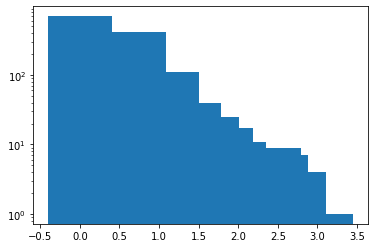

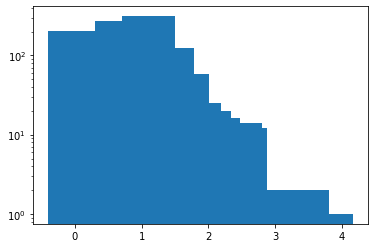

In [63]:
plt.bar(np.log(np.array(list(ac.items())).T[0]),np.array(list(ac.items())).T[1])
plt.yscale('log')
plt.show()
plt.bar(np.log(np.array(list(bc.items())).T[0]),np.array(list(bc.items())).T[1])
plt.yscale('log')

In [64]:
# to do:
# fit the log-normal instead of returning the max
# execute a fit on the "old" dataset

In [86]:
sum(([1,1,1]*res_r[10][10])**2)

1.0

# Watershed

In [11]:
cs1.render_image('cyto_test', )

TypeError: render_image() got an unexpected keyword argument 'z'